In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
SEED = 1780
torch.manual_seed(SEED);

In [3]:
# Read training set
train_df = pd.read_csv("updated_medical_train.csv")
train = train_df.drop(columns='Medical Cost').to_numpy(dtype='float64', copy=True)
train_y = train_df['Medical Cost'].to_numpy(dtype='float64', copy=True)

# Convert to 2D PyTorch tensors
X = torch.tensor(train, dtype=torch.float32)
y = torch.tensor(train_y, dtype=torch.float32).reshape(-1, 1)

print(X.shape)
print(y.shape)

torch.Size([6000, 8])
torch.Size([6000, 1])


In [4]:
# Read validation set
val_df = pd.read_csv("updated_medical_validate.csv")
val = val_df.drop(columns='Medical Cost').to_numpy(dtype='float64', copy=True)
val_y = val_df['Medical Cost'].to_numpy(dtype='float64', copy=True)

# Convert to 2D PyTorch tensors
X_val = torch.tensor(val, dtype=torch.float32)
y_val = torch.tensor(val_y, dtype=torch.float32).reshape(-1, 1)

print(X_val.shape)
print(y_val.shape)

torch.Size([2000, 8])
torch.Size([2000, 1])


In [5]:
# Read test set
test_df = pd.read_csv("updated_medical_test.csv")
test = test_df.drop(columns='Medical Cost').to_numpy(dtype='float64', copy=True)
test_y = test_df['Medical Cost'].to_numpy(dtype='float64', copy=True)

# Convert to 2D PyTorch tensors
X_test = torch.tensor(test, dtype=torch.float32)
y_test = torch.tensor(test_y, dtype=torch.float32).reshape(-1, 1)

print(X_test.shape)
print(y_test.shape)

torch.Size([2000, 8])
torch.Size([2000, 1])


In [6]:
# Define PyTorch model, with dropout at hidden layers
class MCDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 32)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(32, 32)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x

In [7]:
def model_train(model, X_train, y_train, n_epochs=300, batch_size=16):
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
      if epoch % 50 == 0:
        print("Epoch:", epoch)
        for start in batch_start:
          X_batch = X_train[start:start+batch_size]
          y_batch = y_train[start:start+batch_size]
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


In [8]:
# Define model
model = MCDropout()

# Train
mse = model_train(model, X, y, n_epochs=1000)

# Get Training RMSE
loss_fn = nn.MSELoss()
y_pred = model(X)
mse = loss_fn(y_pred, y)
print("Training RMSE:", np.sqrt(mse.detach().numpy()))

Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Epoch: 500
Epoch: 550
Epoch: 600
Epoch: 650
Epoch: 700
Epoch: 750
Epoch: 800
Epoch: 850
Epoch: 900
Epoch: 950
Training RMSE: 0.056457423


In [9]:
# Get Validation RMSE
y_pred = model(X_val)
mse = loss_fn(y_pred, y_val)
print("Validation RMSE:", np.sqrt(mse.detach().numpy()))

# Get Test RMSE
y_pred = model(X_test)
mse = loss_fn(y_pred, y_test)
print("Test RMSE:", np.sqrt(mse.detach().numpy()))

Validation RMSE: 0.05686227
Test RMSE: 0.056397025


In [10]:
# Get predictions by making T stochastic forward passes
def get_predictions(X, df, T=100):
  results = None
  for i in range(T):
    y_pred = model(X)
    iter = y_pred.detach().numpy()

    if i == 0:
      results = iter
    else:
      results = np.append(results, iter, axis=1)

  mu = np.mean(results, axis=1)
  sigma = np.std(results, ddof=1, axis=1)

  predictions = df.copy()
  predictions['Mean'] = mu
  predictions['Uncertainty'] = sigma
  predictions = predictions[['Medical Cost', 'Mean', 'Uncertainty']]

  return predictions

predictions_val = get_predictions(X_val, val_df)
predictions_test = get_predictions(X_test, test_df)

In [11]:
def qce(predictions, n_quantiles, n_bins, filename, scale=1):
  quantiles = np.linspace(0, 1, n_quantiles+1)

  test_predictions = predictions.copy()

  test_predictions['Uncertainty'] = scale * test_predictions['Uncertainty']
  df = test_predictions

  # Variance ranges for binning
  cutoffs = np.linspace(df['Uncertainty'].iloc[0],
                        df['Uncertainty'].iloc[len(df)-1],
                        n_bins+1)

  error = 0.0
  observed = []

  # For each confidence level
  for p in quantiles:
    bin_freqs = [0 for _ in range(n_bins)]
    bin_counts = [0 for _ in range(n_bins)]
    i = 0
    # For each prediction
    for j in range(len(df)):
      point = df.iloc[j]
      mu = point['Mean']
      s = point['Uncertainty']
      y = point['Medical Cost']

      # Place point in appropriate bin
      if s > cutoffs[i+1]:
        i += 1
      bin_counts[i] += 1

      # Calculate confidence interval
      z = stats.norm.ppf((1 + p) / 2)
      if np.abs(mu - y) <= z * s:
        bin_freqs[i] += 1

    freq = [bin_freqs[i]/bin_counts[i] for i,_ in enumerate(bin_freqs)]
    qce = sum(bin_counts[i] * np.abs(freq[i] - p) for i,_ in enumerate(freq))
    empirical = sum(bin_counts[i] * freq[i] for i,_ in enumerate(freq))
    observed.append(empirical / len(df))
    error += (qce / len(df))

  error = error / (n_quantiles+1)

  if filename == None:
    return error

  fig, ax = plt.subplots()
  ax.plot(quantiles, observed, linewidth=2, alpha=.5)
  ax.plot(quantiles, quantiles, linewidth=2, alpha=.5)

  ax.set_xlabel(r'Expected Confidence Level')
  ax.set_ylabel(r'Observed Confidence Level')
  ax.grid()

  print("QCE: ", error)

  plt.savefig(filename)
  return error

QCE:  0.16881818181818178


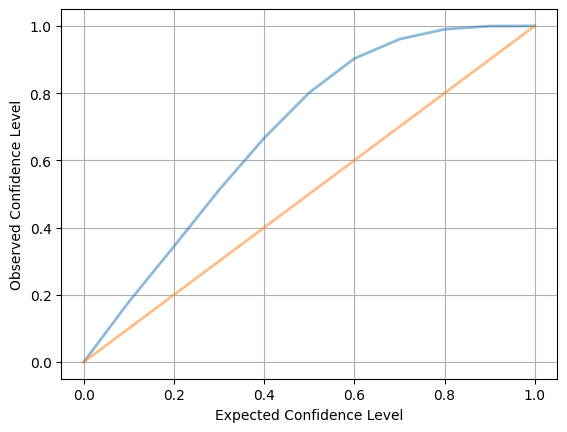

In [12]:
# Sort predictions by Uncertainty
predictions_val = predictions_val.sort_values('Uncertainty')

# Get QCE on Validation Set
qce_pre_calibration = qce(predictions_val, 10, 10, "dropout_pre_calibration_plot")

In [13]:
# Perform grid search to find optimal global uncertainty scaling factor
def qce_calibrate(predictions, start, end, num_iters):
  vals = np.linspace(start, end, num=num_iters)
  opt_scale = None
  opt = None
  for val in vals:
    if val == 0:
      continue
    score = qce(predictions, 10, 10, None, scale=val)
    print("Scale: {:.03f} QCE: {:.03f}".format(val, score))
    if opt == None or score < opt:
      opt = score
      opt_scale = val

  return opt_scale

validate_scale = qce_calibrate(predictions_val, 0.5, 0.55, 20)

Scale: 0.500 QCE: 0.027
Scale: 0.503 QCE: 0.026
Scale: 0.505 QCE: 0.026
Scale: 0.508 QCE: 0.025
Scale: 0.511 QCE: 0.024
Scale: 0.513 QCE: 0.024
Scale: 0.516 QCE: 0.023
Scale: 0.518 QCE: 0.022
Scale: 0.521 QCE: 0.021
Scale: 0.524 QCE: 0.021
Scale: 0.526 QCE: 0.021
Scale: 0.529 QCE: 0.020
Scale: 0.532 QCE: 0.020
Scale: 0.534 QCE: 0.020
Scale: 0.537 QCE: 0.020
Scale: 0.539 QCE: 0.021
Scale: 0.542 QCE: 0.021
Scale: 0.545 QCE: 0.022
Scale: 0.547 QCE: 0.022
Scale: 0.550 QCE: 0.023


QCE:  0.020299999999999995


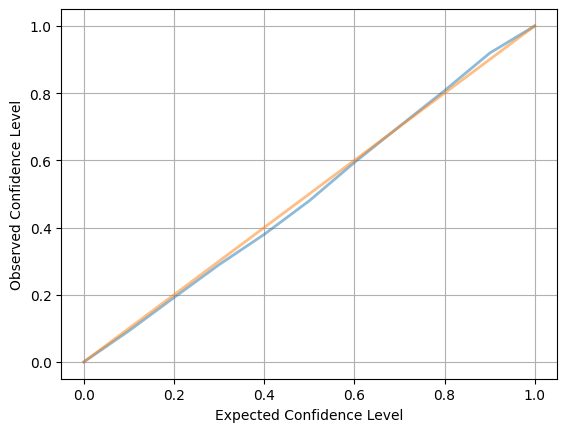

In [14]:
qce_post_calibration = qce(predictions_val, 10, 10, "dropout_post_calibration_plot", scale=validate_scale)

QCE:  0.02006363636363637


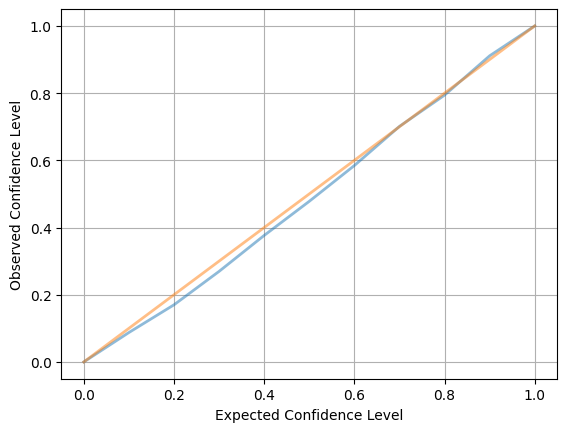

In [15]:
# Sort predictions by Uncertainty
predictions_test = predictions_test.sort_values('Uncertainty')

# Get final QCE on test set
qce_test = qce(predictions_test, 10, 10, "dropout_test_plot", scale=validate_scale)